# Text Classification - Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
train_data=pd.read_csv("D:/6th Semester/Conversational AI-NLP/Lab/sentiment_dataset/train.csv")
test_data=pd.read_csv("D:/6th Semester/Conversational AI-NLP/Lab/sentiment_dataset/test.csv")

In [3]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
# Remove the null values from the dataset
train_data.dropna(axis=0,how='any',inplace=True)
test_data.dropna(axis=0,how='any',inplace=True)

In [5]:
# Removing text with less than 2 characters as it give very less information
train_data['num_words']=train_data['text'].apply(lambda x: len(str(x).split()))
mask=train_data['num_words']>2
train_data=train_data[mask]
print(mask)
test_data['num_words']=test_data['text'].apply(lambda x: len(str(x).split()))
mask=test_data['num_words']>2
test_data=test_data[mask]

0        True
1        True
2        True
3        True
4        True
         ... 
27476    True
27477    True
27478    True
27479    True
27480    True
Name: num_words, Length: 27480, dtype: bool


In [6]:
# Remove Emoji's, flags, symbols, urls, digits, special characters, etc.
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" #emoticons
                               u"\U0001F300-\U0001F5FF" #symbols & pictographs
                               u"\U0001F680-\U0001F6FF" #transport & map symbols
                               u"\U0001F1E0-\U0001F1FF" #flags(iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'',str(text))

def remove_url(text):
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'',text)

def clean_text(text):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' ']=' '
    table=str.maketrans(delete_dict)
    text1=str(text).translate(table)
    textArr=str(text1).split()
    text2=' '.join([w for w in textArr if (not w.isdigit() and (not w.isdigit() and len(w)>3))])
    return text2.lower()

In [7]:
train_data['text']=train_data['text'].apply(remove_emoji)
train_data['text']=train_data['text'].apply(remove_url)
train_data['text']=train_data['text'].apply(clean_text)

test_data['text']=test_data['text'].apply(remove_emoji)
test_data['text']=test_data['text'].apply(remove_url)
test_data['text']=test_data['text'].apply(clean_text)

In [8]:
train_x,valid_x,train_y,valid_y=train_test_split(train_data['text'].tolist(),train_data['sentiment'].tolist(),random_state=0,test_size=0.33,stratify=train_data['sentiment'].tolist())

In [9]:
le=LabelEncoder()
train_y=le.fit_transform(train_y)

In [10]:
train_y

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [11]:
train_y=keras.utils.to_categorical(train_y)
train_y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [12]:
valid_y=le.fit_transform(valid_y)
valid_y=keras.utils.to_categorical(valid_y)

test_y=le.transform(test_data['sentiment'].tolist())
test_y=keras.utils.to_categorical(test_y)

In [13]:
train_x=np.array(train_x)
valid_x=np.array(valid_x)
test_x=np.array(test_data['text'].tolist())

In [14]:
# making tensors 
train_ds=tf.data.Dataset.from_tensor_slices((train_x,train_y))
valid_ds=tf.data.Dataset.from_tensor_slices((valid_x,valid_y))
test_ds=tf.data.Dataset.from_tensor_slices((test_x,test_y))

In [15]:
# tensorflow hub - we can use pretrained models from the hub
# we are using an embedding by google which is of 20 dimensions
embedding ='https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'
hub_layer=hub.KerasLayer(embedding,trainable=True,input_shape=[],dtype=tf.string)

In [16]:
print(train_x[:1])

['just getting additional free']


In [17]:
hub_layer(train_x[:1])

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.02252544, -1.102936  , -0.45312536,  1.1712923 , -0.9280152 ,
        -1.6799717 , -0.03097978, -0.04522766, -0.69689393, -0.3546787 ,
        -0.9819268 ,  1.3606595 , -0.7599448 ,  0.05979407, -0.71509284,
         0.48663723,  1.3430784 , -1.0147772 ,  0.13958323, -0.14541228]],
      dtype=float32)>

In [18]:
model=keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(3,activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                389380    
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['CategoricalAccuracy'],
             optimizer='adam')

In [21]:
history=model.fit(train_ds.batch(128),
         epochs=20,
         validation_data=valid_ds.batch(128))

Epoch 1/20


c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


141/141 [==============================] - 2s 11ms/step - loss: 1.0960 - categorical_accuracy: 0.4101 - val_loss: 1.0256 - val_categorical_accuracy: 0.4858
Epoch 2/20
141/141 [==============================] - 1s 9ms/step - loss: 0.9878 - categorical_accuracy: 0.5213 - val_loss: 0.9657 - val_categorical_accuracy: 0.5406
Epoch 3/20
141/141 [==============================] - 1s 10ms/step - loss: 0.9235 - categorical_accuracy: 0.5700 - val_loss: 0.9205 - val_categorical_accuracy: 0.5679
Epoch 4/20
141/141 [==============================] - 1s 10ms/step - loss: 0.8667 - categorical_accuracy: 0.6063 - val_loss: 0.8844 - val_categorical_accuracy: 0.5895
Epoch 5/20
141/141 [==============================] - 2s 12ms/step - loss: 0.8163 - categorical_accuracy: 0.6369 - val_loss: 0.8567 - val_categorical_accuracy: 0.6088
Epoch 6/20
141/141 [==============================] - 2s 12ms/step - loss: 0.7734 - categorical_accuracy: 0.6640 - val_loss: 0.8378 - val_categorical_accuracy: 0.6216
Epoch 7/20

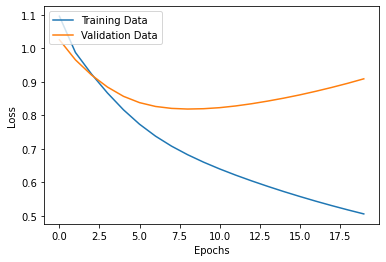

In [22]:
plt.plot(history.history['loss'],label='Training Data')
plt.plot(history.history['val_loss'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

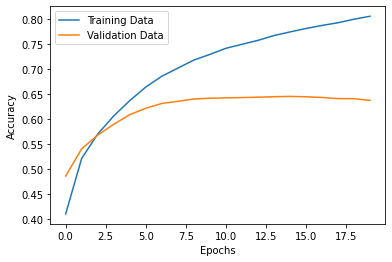

In [32]:
plt.plot(history.history['categorical_accuracy'],label='Training Data')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [24]:
model1=keras.Sequential()
model1.add(hub_layer)
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(10,activation='relu',kernel_regularizer=keras.regularizers.l2(0.05)))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(3,activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.05)))

In [25]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                389380    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


In [26]:
model1.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['CategoricalAccuracy'],
             optimizer='adam')

In [27]:
history1=model1.fit(train_ds.shuffle(1000).batch(128),
         epochs=60,
         validation_data=valid_ds.batch(128)) 

Epoch 1/60
141/141 [==============================] - 2s 10ms/step - loss: 2.0087 - categorical_accuracy: 0.3640 - val_loss: 1.5237 - val_categorical_accuracy: 0.4205
Epoch 2/60
141/141 [==============================] - 1s 9ms/step - loss: 1.4649 - categorical_accuracy: 0.4008 - val_loss: 1.3114 - val_categorical_accuracy: 0.4144
Epoch 3/60
141/141 [==============================] - 1s 10ms/step - loss: 1.2644 - categorical_accuracy: 0.4342 - val_loss: 1.1910 - val_categorical_accuracy: 0.4531
Epoch 4/60
141/141 [==============================] - 1s 9ms/step - loss: 1.1580 - categorical_accuracy: 0.4779 - val_loss: 1.1092 - val_categorical_accuracy: 0.5446
Epoch 5/60
141/141 [==============================] - 1s 10ms/step - loss: 1.0971 - categorical_accuracy: 0.4946 - val_loss: 1.0624 - val_categorical_accuracy: 0.5754
Epoch 6/60
141/141 [==============================] - 1s 9ms/step - loss: 1.0640 - categorical_accuracy: 0.5130 - val_loss: 1.0348 - val_categorical_accuracy: 0.5848
E

Epoch 50/60
141/141 [==============================] - 1s 9ms/step - loss: 0.8628 - categorical_accuracy: 0.6640 - val_loss: 0.8819 - val_categorical_accuracy: 0.6577
Epoch 51/60
141/141 [==============================] - 1s 10ms/step - loss: 0.8603 - categorical_accuracy: 0.6565 - val_loss: 0.8829 - val_categorical_accuracy: 0.6568
Epoch 52/60
141/141 [==============================] - 2s 12ms/step - loss: 0.8631 - categorical_accuracy: 0.6571 - val_loss: 0.8815 - val_categorical_accuracy: 0.6595
Epoch 53/60
141/141 [==============================] - 1s 10ms/step - loss: 0.8592 - categorical_accuracy: 0.6624 - val_loss: 0.8809 - val_categorical_accuracy: 0.6594
Epoch 54/60
141/141 [==============================] - 2s 11ms/step - loss: 0.8569 - categorical_accuracy: 0.6618 - val_loss: 0.8813 - val_categorical_accuracy: 0.6587
Epoch 55/60
141/141 [==============================] - 2s 11ms/step - loss: 0.8560 - categorical_accuracy: 0.6660 - val_loss: 0.8789 - val_categorical_accuracy: 

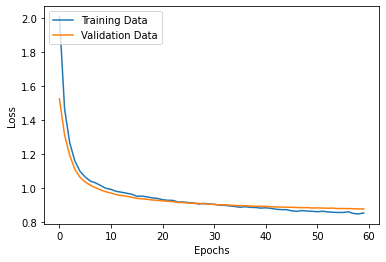

In [29]:
plt.plot(history1.history['loss'],label='Training Data')
plt.plot(history1.history['val_loss'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

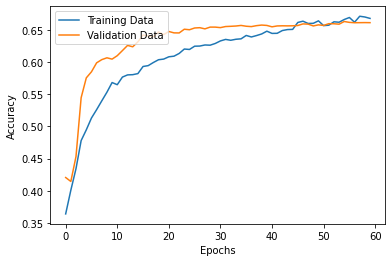

In [31]:
plt.plot(history1.history['categorical_accuracy'],label='Training Data')
plt.plot(history1.history['val_categorical_accuracy'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [33]:
model1.evaluate(test_x,test_y)

108/108 [==============================] - 0s 3ms/step - loss: 0.8658 - categorical_accuracy: 0.6680


[0.8657997846603394, 0.6680256128311157]